In [ ]:
! pip install openml

import openml
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


dataset_id = 45069

dataset = openml.datasets.get_dataset(dataset_id)
X, y, categorical_indicator, attribute_names = dataset.get_data(target=dataset.default_target_attribute)


if y is not None:
    df = pd.concat([X, y], axis=1)
else:
    df = X

print(df.head())


   admission_type_id  discharge_disposition_id  admission_source_id  \
0                  1                         3                    7   
1                  5                         1                    1   
2                  2                         1                    1   
3                  3                         1                    1   
4                  3                         1                    1   

   time_in_hospital  num_lab_procedures  num_procedures  num_medications  \
0                 4                  41               2               17   
1                 3                  64               0               10   
2                 2                  39               0                8   
3                 1                  39               2               12   
4                 3                  21               2               23   

   number_outpatient  number_emergency  number_inpatient  ...  citoglipton  \
0                  0                 0

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 48 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   admission_type_id         101766 non-null  uint8   
 1   discharge_disposition_id  101766 non-null  uint8   
 2   admission_source_id       101766 non-null  uint8   
 3   time_in_hospital          101766 non-null  uint8   
 4   num_lab_procedures        101766 non-null  uint8   
 5   num_procedures            101766 non-null  uint8   
 6   num_medications           101766 non-null  uint8   
 7   number_outpatient         101766 non-null  uint8   
 8   number_emergency          101766 non-null  uint8   
 9   number_inpatient          101766 non-null  uint8   
 10  number_diagnoses          101766 non-null  uint8   
 11  race                      99493 non-null   category
 12  gender                    101766 non-null  category
 13  age                       101

In [ ]:
df.nunique()

,0
admission_type_id,8
discharge_disposition_id,26
admission_source_id,17
time_in_hospital,14
num_lab_procedures,118
num_procedures,7
num_medications,75
number_outpatient,39
number_emergency,33
number_inpatient,21


In [ ]:
columns_to_drop = ['examide', 'citoglipton']

df = df.drop(columns=columns_to_drop)

print(f"Columns {columns_to_drop} have been dropped.")
print("\nDataFrame columns after dropping:")
print(df.columns)

Columns ['examide', 'citoglipton'] have been dropped.

DataFrame columns after dropping:
Index(['admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses', 'race', 'gender', 'age',
       'weight', 'payer_code', 'medical_specialty', 'diag_1', 'diag_2',
       'diag_3', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide',
       'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide',
       'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone',
       'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide',
       'insulin', 'glyburide.metformin', 'glipizide.metformin',
       'glimepiride.pioglitazone', 'metformin.rosiglitazone',
       'metformin.pioglitazone', 'change', 'diabetesMed', 'class'],
      dtype='object')


In [ ]:
categorical_cols = df.select_dtypes(include='category').columns

print("Unique values for categorical columns after dropping 'examide' and 'citoglipton':")

for col in categorical_cols:
    print(f"\nColumn: {col}")
    print(df[col].unique())

Unique values for categorical columns after dropping 'examide' and 'citoglipton':

Column: race
['AfricanAmerican', 'Caucasian', 'Hispanic', 'Other', NaN, 'Asian']
Categories (5, object): ['AfricanAmerican' < 'Asian' < 'Caucasian' < 'Hispanic' < 'Other']

Column: gender
['Female', 'Male', 'Unknown/Invalid']
Categories (3, object): ['Female' < 'Male' < 'Unknown/Invalid']

Column: age
['[60-70)', '[50-60)', '[80-90)', '[40-50)', '[70-80)', '[90-100)', '[10-20)', '[30-40)', '[20-30)', '[0-10)']
Categories (10, object): ['[0-10)' < '[10-20)' < '[20-30)' < '[30-40)' ... '[60-70)' < '[70-80)' <
                          '[80-90)' < '[90-100)']

Column: weight
[NaN, '[75-100)', '[50-75)', '[125-150)', '[100-125)', '[25-50)', '[150-175)', '[0-25)', '>200', '[175-200)']
Categories (9, object): ['>200' < '[0-25)' < '[100-125)' < '[125-150)' ... '[175-200)' < '[25-50)' <
                         '[50-75)' < '[75-100)']

Column: payer_code
['MC', 'MD', NaN, 'BC', 'SP', ..., 'DM', 'WC', 'SI', 'OT',

In [ ]:
df.describe()

,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000
mean,2.024006,3.715642,5.754437,4.395987,43.095641,1.339730,16.021844,0.369357,0.197836,0.635566,7.422607
std,1.445403,5.280166,4.064081,2.985108,19.674362,1.705807,8.127566,1.267265,0.930472,1.262863,1.933600
min,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,1.000000,1.000000,1.000000,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000
50%,1.000000,1.000000,7.000000,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000
75%,3.000000,4.000000,7.000000,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,8.000000,28.000000,25.000000,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,16.000000


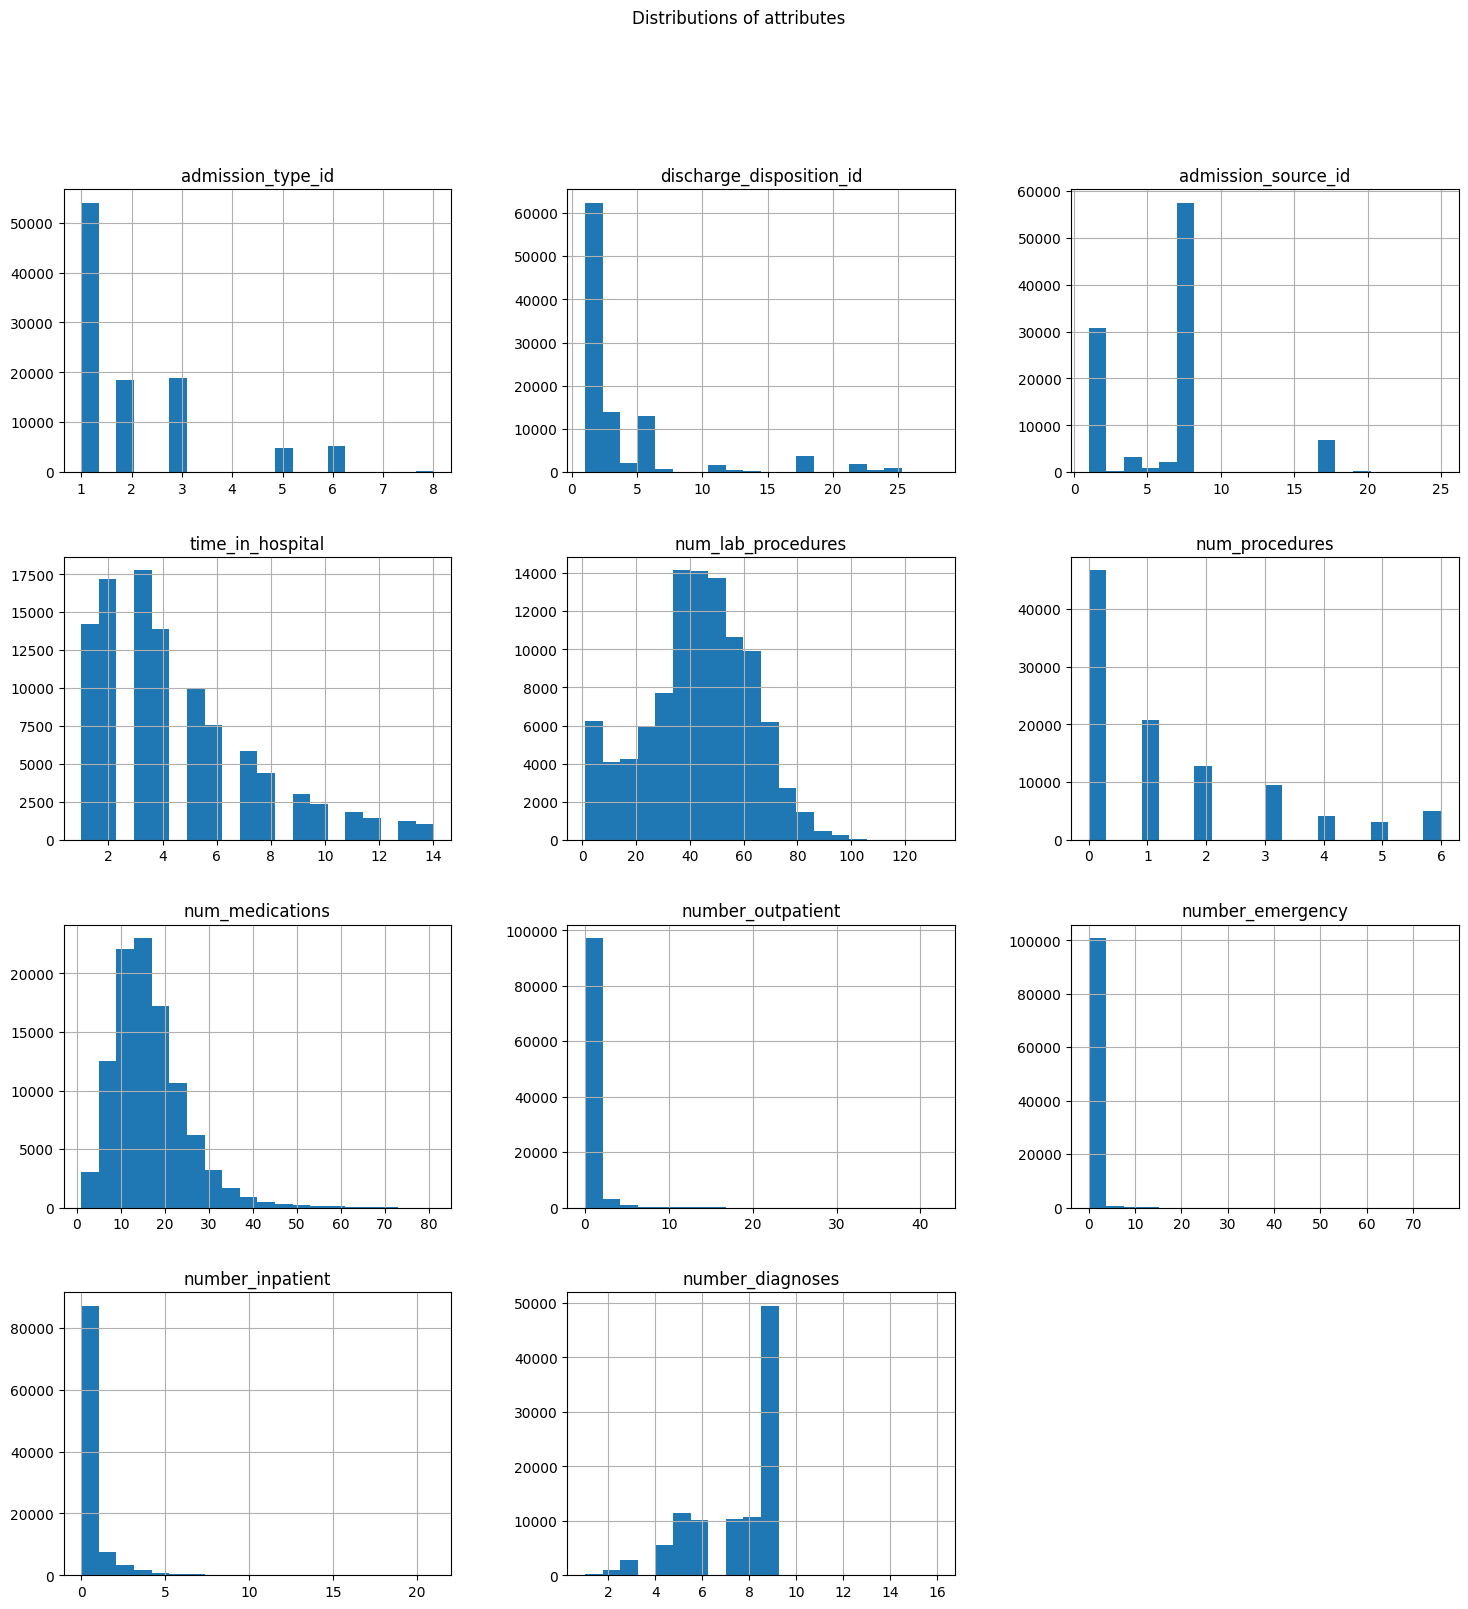

In [ ]:
df.hist(figsize=(18, 18), bins=20)
plt.suptitle("Distributions of attributes")
plt.show()

In [ ]:
print("Shape of the DataFrame before removing duplicates:", df.shape)

df.drop_duplicates(inplace=True)

print("Shape of the DataFrame after removing duplicates:", df.shape)

Shape of the DataFrame before removing duplicates: (101766, 46)
Shape of the DataFrame after removing duplicates: (101766, 46)


In [ ]:
print(df.isnull().sum())

admission_type_id               0
discharge_disposition_id        0
admission_source_id             0
time_in_hospital                0
num_lab_procedures              0
num_procedures                  0
num_medications                 0
number_outpatient               0
number_emergency                0
number_inpatient                0
number_diagnoses                0
race                         2273
gender                          0
age                             0
weight                      98569
payer_code                  40256
medical_specialty           49949
diag_1                         21
diag_2                        358
diag_3                       1423
max_glu_serum                   0
A1Cresult                       0
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride                     0
acetohexamide                   0
glipizide                       0
glyburide     

In [ ]:
categorical_cols_with_missing = ['race', 'payer_code', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3']


for col in categorical_cols_with_missing:
    if col in df.columns:
        if pd.api.types.is_categorical_dtype(df[col].dtype):
            if 'Missing' not in df[col].cat.categories:
                df[col] = df[col].cat.add_categories('Missing')
        df[col].fillna('Missing', inplace=True)

print("Missing values after imputation:")
display(df[categorical_cols_with_missing + ['weight']].isnull().sum())

Missing values after imputation:


/tmp/ipython-input-179757292.py:6: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(df[col].dtype):
/tmp/ipython-input-179757292.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna('Missing', inplace=True)


,0
race,0
payer_code,0
medical_specialty,0
diag_1,0
diag_2,0
diag_3,0
weight,98569


Boxplots of numerical columns (excluding IDs):


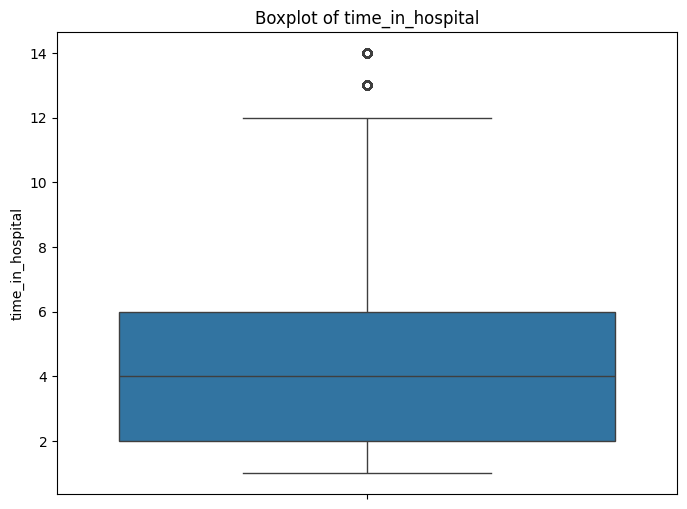

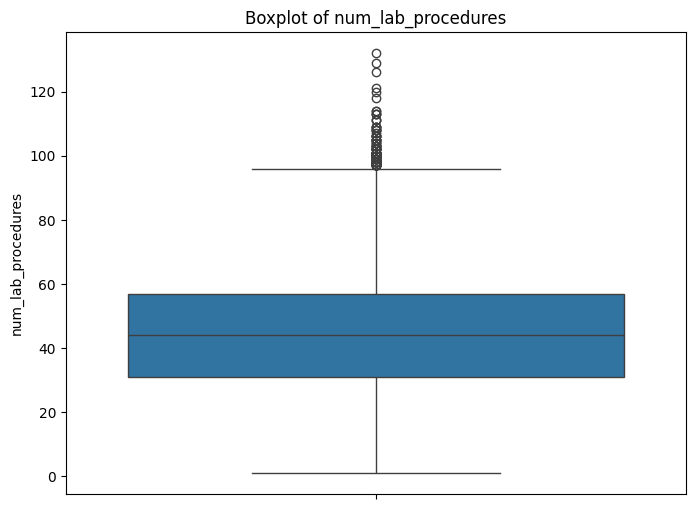

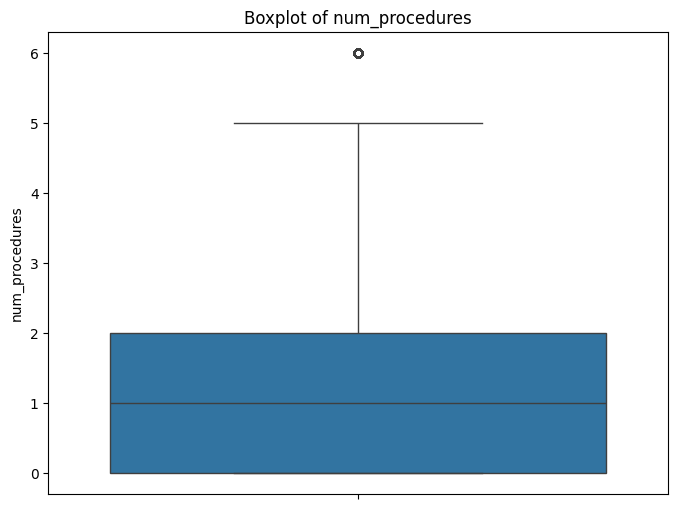

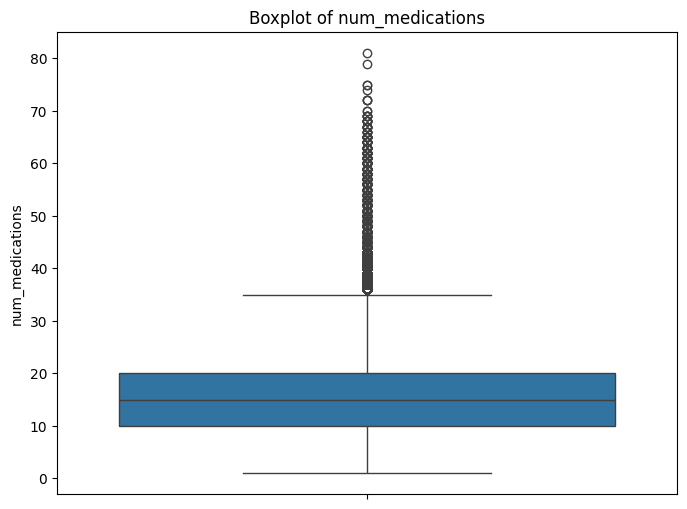

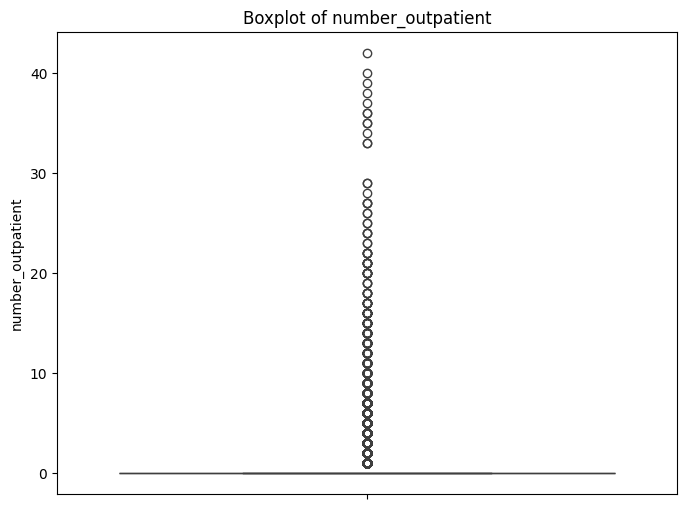

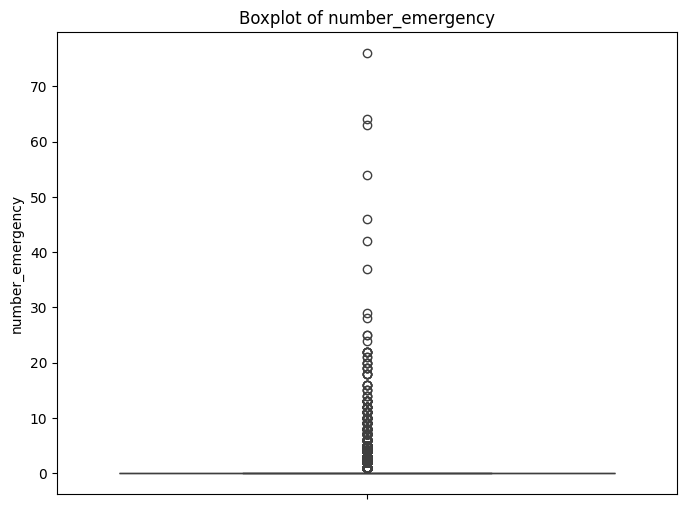

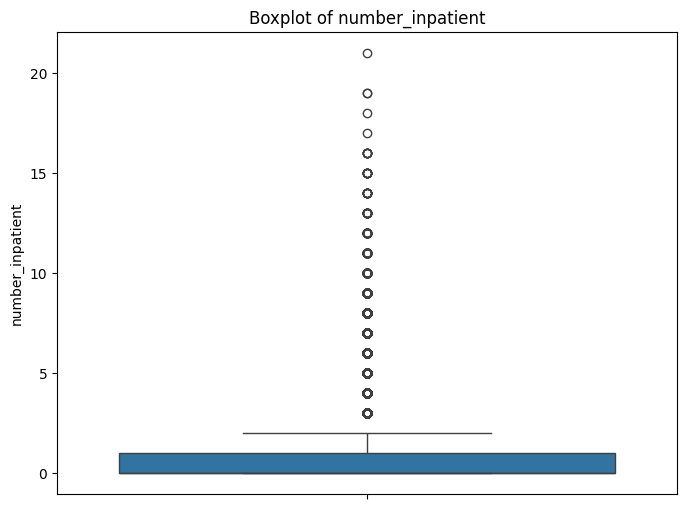

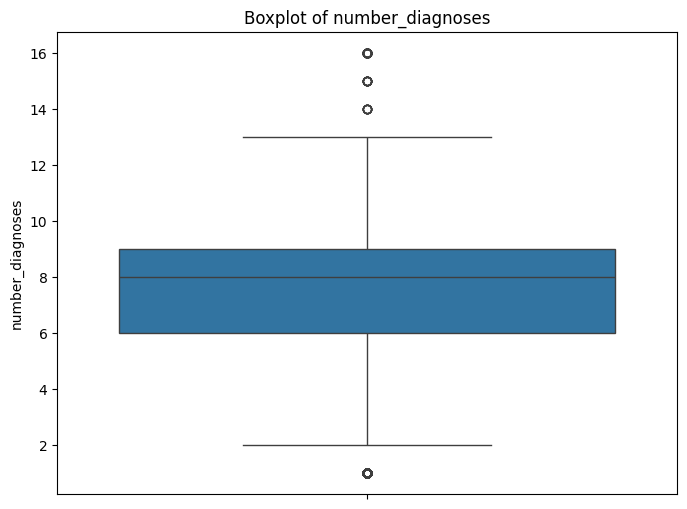

In [ ]:

numerical_cols = df.select_dtypes(include=['int64', 'float64', 'uint8']).columns

id_cols = ['admission_type_id', 'discharge_disposition_id', 'admission_source_id']
numerical_cols_for_plotting = [col for col in numerical_cols if col not in id_cols]

print("Boxplots of numerical columns (excluding IDs):")
for col in numerical_cols_for_plotting:
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=df, y=col)
    plt.title(f'Boxplot of {col}')
    plt.ylabel(col)
    plt.show()

In [ ]:
numerical_cols_for_plotting = [col for col in df.select_dtypes(include=['int64', 'float64', 'uint8']).columns if col not in ['admission_type_id', 'discharge_disposition_id', 'admission_source_id']]

print("Number of outliers for each numerical column (excluding IDs) using IQR method:")

for col in numerical_cols_for_plotting:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    num_outliers = outliers.shape[0]

    print(f"Column '{col}': {num_outliers} outliers")

Number of outliers for each numerical column (excluding IDs) using IQR method:
Column 'time_in_hospital': 2252 outliers
Column 'num_lab_procedures': 143 outliers
Column 'num_procedures': 4954 outliers
Column 'num_medications': 2557 outliers
Column 'number_outpatient': 16739 outliers
Column 'number_emergency': 11383 outliers
Column 'number_inpatient': 7049 outliers
Column 'number_diagnoses': 281 outliers


In [ ]:
df_processed_iqr = df.copy()

columns_to_cap_iqr = ['number_diagnoses', 'num_lab_procedures', 'num_medications', 'num_procedures', 'time_in_hospital']

print(f"Applying IQR-based outlier capping to columns: {columns_to_cap_iqr}...")

for col in columns_to_cap_iqr:
    if col in df_processed_iqr.columns:
        Q1 = df_processed_iqr[col].quantile(0.25)
        Q3 = df_processed_iqr[col].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        df_processed_iqr[col] = df_processed_iqr[col].apply(lambda x: lower_bound if x < lower_bound else x)

        df_processed_iqr[col] = df_processed_iqr[col].apply(lambda x: upper_bound if x > upper_bound else x)
    else:
        print(f"Column '{col}' not found in DataFrame.")

print("IQR-based outlier capping applied.")

print("\nDescriptive Statistics for capped columns after IQR capping:")
display(df_processed_iqr[columns_to_cap_iqr].describe())

Applying IQR-based outlier capping to columns: ['number_diagnoses', 'num_lab_procedures', 'num_medications', 'num_procedures', 'time_in_hospital']...
IQR-based outlier capping applied.

Descriptive Statistics for capped columns after IQR capping:


,number_diagnoses,num_lab_procedures,num_medications,num_procedures,time_in_hospital
count,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000
mean,7.422395,43.087210,15.808512,1.291050,4.363618
std,1.925325,19.648915,7.396645,1.581884,2.892181
min,1.500000,1.000000,1.000000,0.000000,1.000000
25%,6.000000,31.000000,10.000000,0.000000,2.000000
50%,8.000000,44.000000,15.000000,1.000000,4.000000
75%,9.000000,57.000000,20.000000,2.000000,6.000000
max,13.500000,96.000000,35.000000,5.000000,12.000000


Boxplots for columns after IQR-based outlier capping:


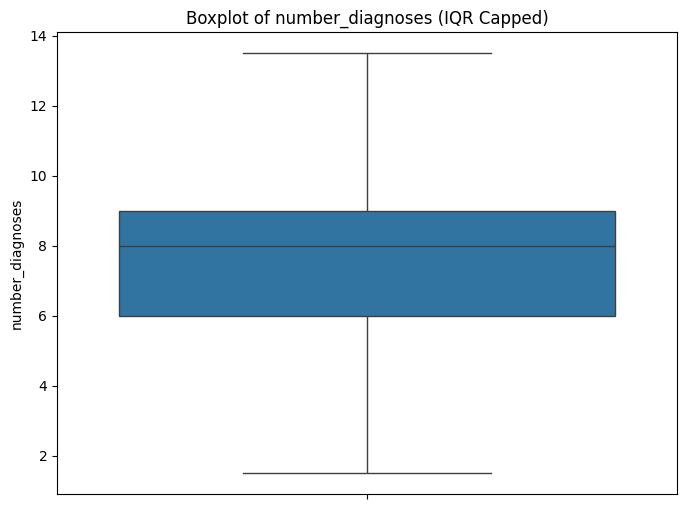

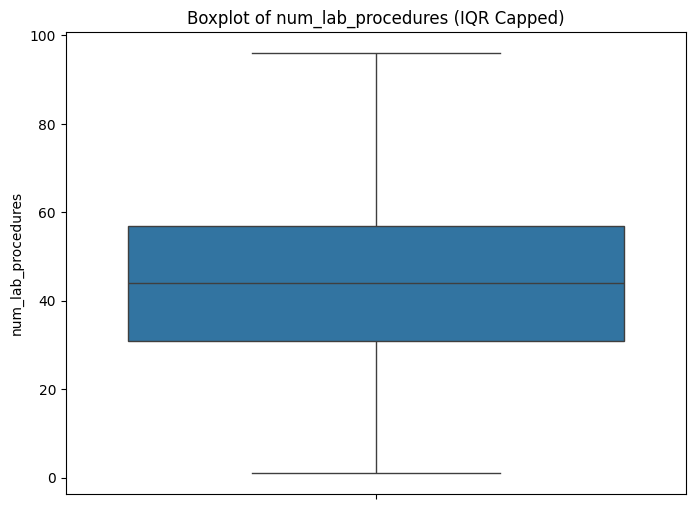

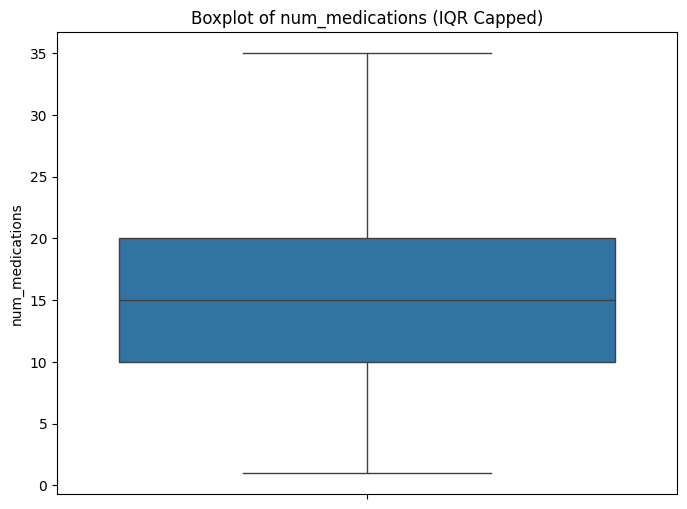

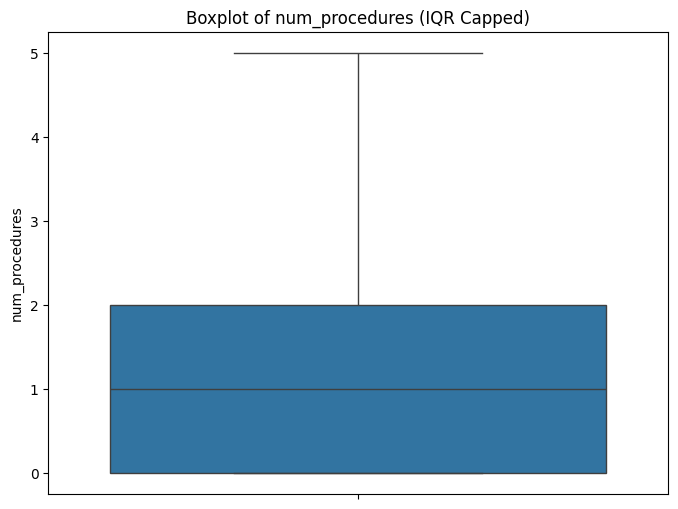

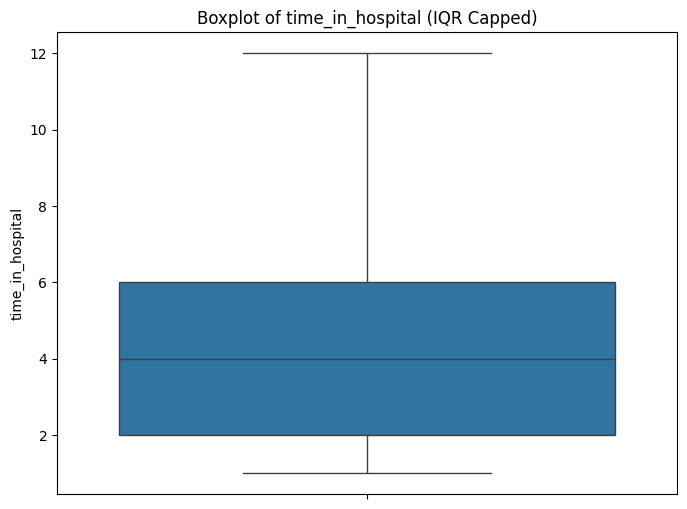

In [ ]:

columns_to_plot_iqr_capped = ['number_diagnoses', 'num_lab_procedures', 'num_medications', 'num_procedures', 'time_in_hospital']

print("Boxplots for columns after IQR-based outlier capping:")

for col in columns_to_plot_iqr_capped:
    if col in df_processed_iqr.columns:
        plt.figure(figsize=(8, 6))
        sns.boxplot(data=df_processed_iqr, y=col)
        plt.title(f'Boxplot of {col} (IQR Capped)')
        plt.ylabel(col)
        plt.show()
    else:
        print(f"Column '{col}' not found in df_processed_iqr.")

In [ ]:
categorical_cols_for_encoding = df.select_dtypes(include='category').columns.tolist()
if 'class' in categorical_cols_for_encoding:
    categorical_cols_for_encoding.remove('class')

df_encoded = pd.get_dummies(df, columns=categorical_cols_for_encoding, drop_first=True)

if 'class' in df_encoded.columns:
    df_encoded = df_encoded.drop(columns=['class'])

print("Shape of the DataFrame after one-hot encoding:", df_encoded.shape)
print("\nDataFrame columns after one-hot encoding:")
print(df_encoded.columns)

correlation_matrix = df_encoded.corrwith(df_encoded['diabetesMed_Yes'])

print("\nCorrelation with 'diabetesMed':")
display(correlation_matrix.sort_values(ascending=False).head(15))
display(correlation_matrix.sort_values(ascending=True).head(10))


Shape of the DataFrame after one-hot encoding: (101766, 2433)

DataFrame columns after one-hot encoding:
Index(['admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient',
       ...
       'insulin_Up', 'glyburide.metformin_No', 'glyburide.metformin_Steady',
       'glyburide.metformin_Up', 'glipizide.metformin_Steady',
       'glimepiride.pioglitazone_Steady', 'metformin.rosiglitazone_Steady',
       'metformin.pioglitazone_Steady', 'change_No', 'diabetesMed_Yes'],
      dtype='object', length=2433)

Correlation with 'diabetesMed':


,0
diabetesMed_Yes,1.000000
insulin_Steady,0.360434
metformin_Steady,0.256281
glipizide_Steady,0.193680
insulin_Up,0.193296
num_medications,0.186910
glyburide_Steady,0.173046
pioglitazone_Steady,0.148253
rosiglitazone_Steady,0.137996
glimepiride_Steady,0.119850


,0
insulin_No,-0.585464
change_No,-0.506370
metformin_No,-0.270176
glipizide_No,-0.206230
glyburide_No,-0.186835
pioglitazone_No,-0.152230
rosiglitazone_No,-0.141157
glimepiride_No,-0.126699
payer_code_Missing,-0.075663
A1Cresult_None,-0.069683


Generating boxplots for numerical columns grouped by 'diabetesMed':


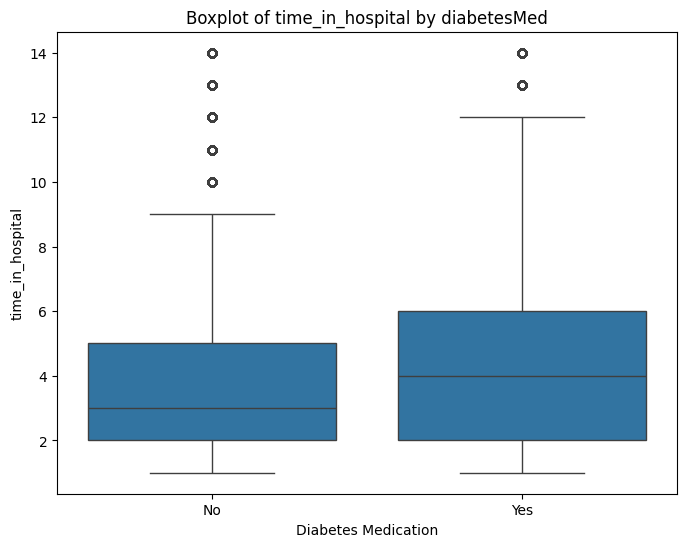

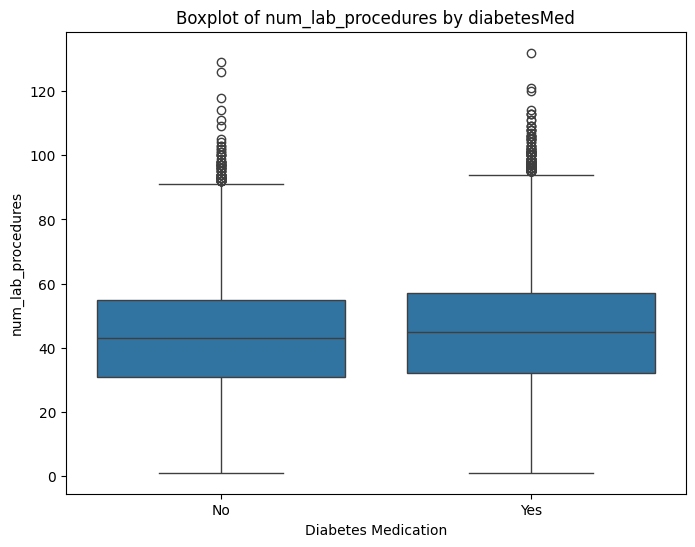

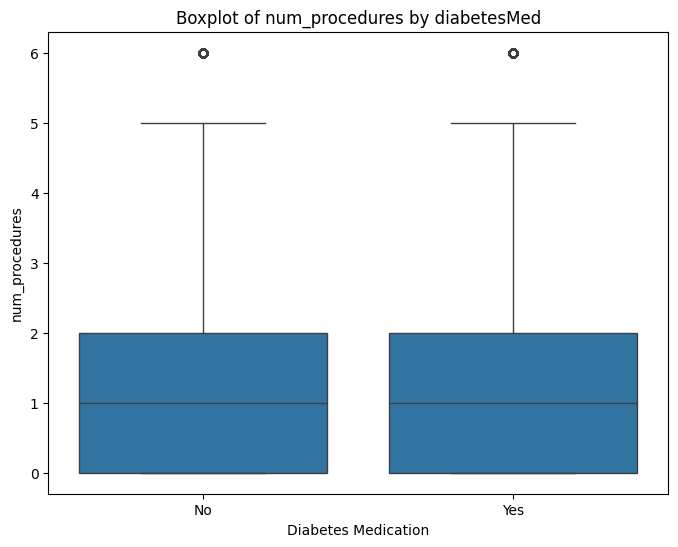

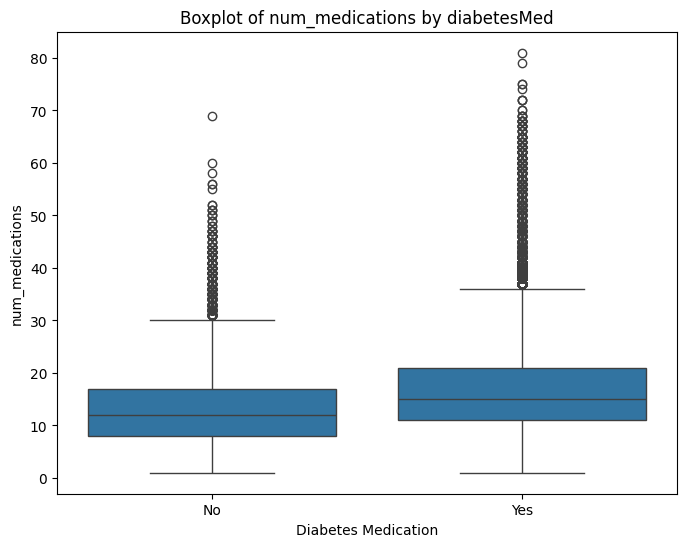

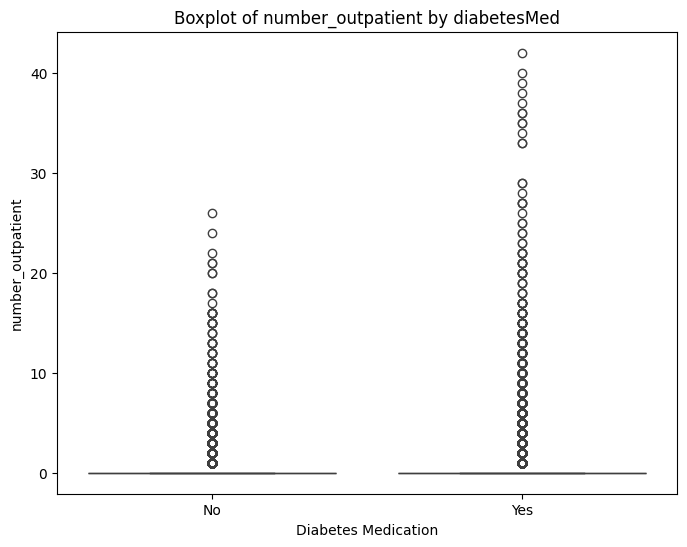

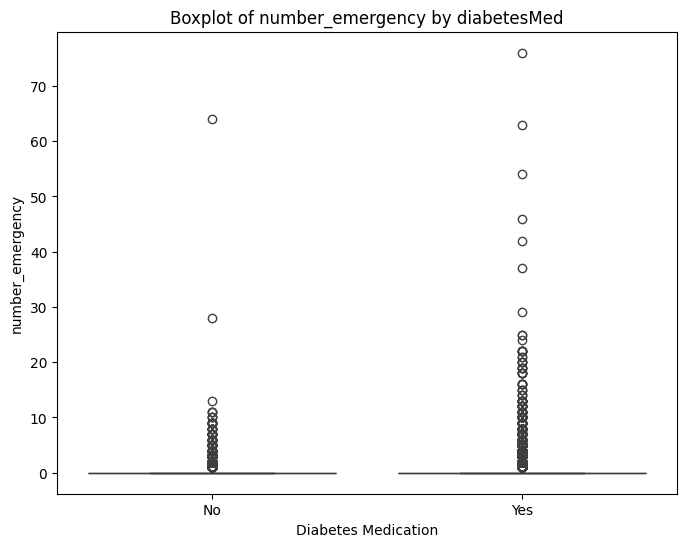

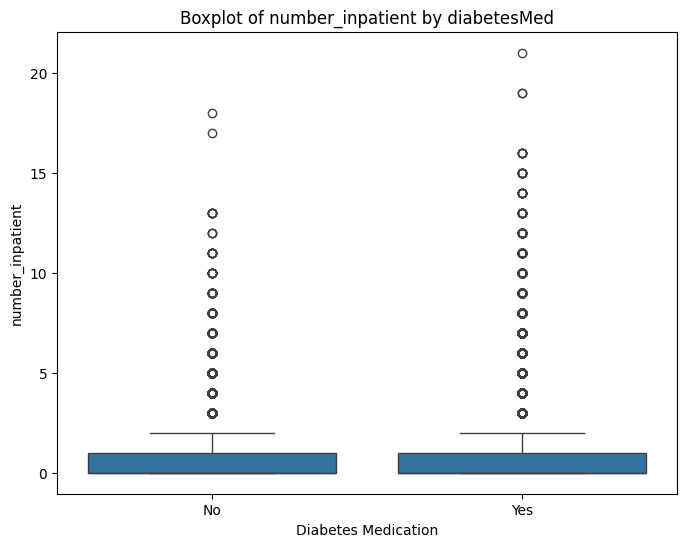

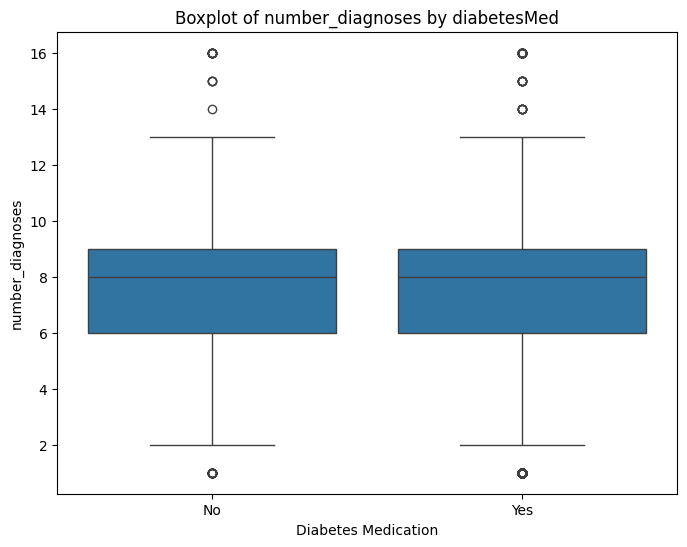

In [ ]:

numerical_cols = df.select_dtypes(include=np.number).columns

id_cols = ['admission_type_id', 'discharge_disposition_id', 'admission_source_id']
numerical_cols_for_plotting = [col for col in numerical_cols if col not in id_cols]

if 'diabetesMed' in df.columns:
    print("Generating boxplots for numerical columns grouped by 'diabetesMed':")

    for col in numerical_cols_for_plotting:
        plt.figure(figsize=(8, 6))
        sns.boxplot(data=df, x='diabetesMed', y=col)
        plt.title(f'Boxplot of {col} by diabetesMed')
        plt.xlabel('Diabetes Medication')
        plt.ylabel(col)
        plt.show()
else:
    print("'diabetesMed' column not found in the DataFrame.")